In [5]:
import random, numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
import glob

In [6]:
alphap = 2 # alpha can only be 1,2 or 3
probp = 0.75 # this value should not be changed


min_iterationp = 100_000 # this value should not be changed

In [7]:
dir_data = "../../data/alpha{}/".format(alphap)
dir_figure =  "../../figures/alpha{}/".format(alphap)

files = glob.glob(dir_data + "data_collapse_alpha_{}_t_*".format(alphap))
filename = dir_data+"function_phi_alpha3_dataframe.csv"

## Function definitions

In [36]:
import scipy.special as sc

n_star = np.linspace(0,1,1_000_001)

def func_trans(n_star,alpha,p):
    """left-hand side of transcendental equation defined as a numpy array"""
    return (sc.gamma(n_star+alpha)*sc.gamma(2*alpha))/(sc.gamma(n_star+2*alpha)*sc.gamma(alpha))-1/(1+p)

In [37]:
def find_df(alpha,p):
    """root finding by minimizing the cost function: square of left-hanad side"""
    cost_array = func_trans(n_star,alpha,p)**2
    min_index = np.argmin(cost_array)
    df_value = n_star[min_index]
    #df_rounded = float("{:.6f}".format(df_value))
    #return df_rounded
    return df_value

In [38]:
import decimal as dc
dc.getcontext().rounding = dc.ROUND_DOWN

def phi_value_alpha_3(df_data,xi,p):
    """
    returns the fuction phi(xi, p) for alpha=3
    
    df_data : pandas DataFrame
    xi      :
    p       : probablity
    """
    
    p_0 = float(round(dc.Decimal(p),2))
    p_1 = float(round(dc.Decimal(p_0+0.01),2))
    del_p = abs(p-p_0)
    
    if del_p <= 1e-9:
        col_name = 'p={:.2f}'.format(p_0)
        phi_list = df_data[col_name].values
    
    else:
        col_name0 = 'p={:.2f}'.format(p_0)
        phi_list0 = df_data[col_name0].values
    
        col_name1 = 'p={:.2f}'.format(p_1)
        phi_list1 = df_data[col_name1].values
        
        del_phi_list =  (phi_list1 - phi_list0)*del_p/0.01
        phi_list = phi_list0 + del_phi_list
    
    xi_list = df_data['xi'].values
    if xi > 2:
        phi_value = 0
    elif xi in xi_list:
        index = list(xi_list).index(xi)
        phi_value = phi_list[index] 
    else:
        index0 = int(xi//0.0002)
        index1 = int(index0+1)
        del_xi = xi%0.0002
        phi_0 = phi_list[index0]
        phi_1 = phi_list[index1]
        del_phi = (phi_1-phi_0)*del_xi/0.0002
        phi_value = phi_0 + del_phi

    return phi_value

def phi_list_alpha_3(df_data,xi_list,p):
    """
    returns the list of phi(p) for a list of xi for alpha=3
    """
    phi_list = []
    for xi in xi_list:
        phi_value = phi_value_alpha_3(df_data,xi,p)
        phi_list.append(phi_value) 

    return np.array(phi_list) 

In [39]:
def phi_list(alpha,p,xi_list):
    """
    analytic function phi for alpha=1,2,3
    """
    df = find_df(alpha,p)
    
    if alpha == 1:
        density = np.exp(-xi_list)
    
    elif alpha == 2:
        c2 = -(sc.gamma(1/3)/sc.gamma(5/3))*(sc.gamma((df+5)/3)/sc.gamma((df+3)/3))
        density1 = -3*(df+2)*(xi_list**2)*sc.hyp1f1(-(df-1)/3, 4/3, -xi_list**3)
        density2 = -(3/5)*c2*df*(xi_list**4)*sc.hyp1f1(-(df-3)/3, 8/3, -xi_list**3)
        density3 = -2*c2*(xi_list)*sc.hyp1f1(-df/3, 5/3, -xi_list**3)
        density = density1 + density2+ density3
    
    elif alpha == 3:
        df_data = pd.read_csv(filename)
        density = phi_list_alpha_3(df_data,xi_list,p)
            
    else:
        print('the analytical solution for alpha = {} value is unknown'.format(alpha))
        
    return density

## data collapse plot

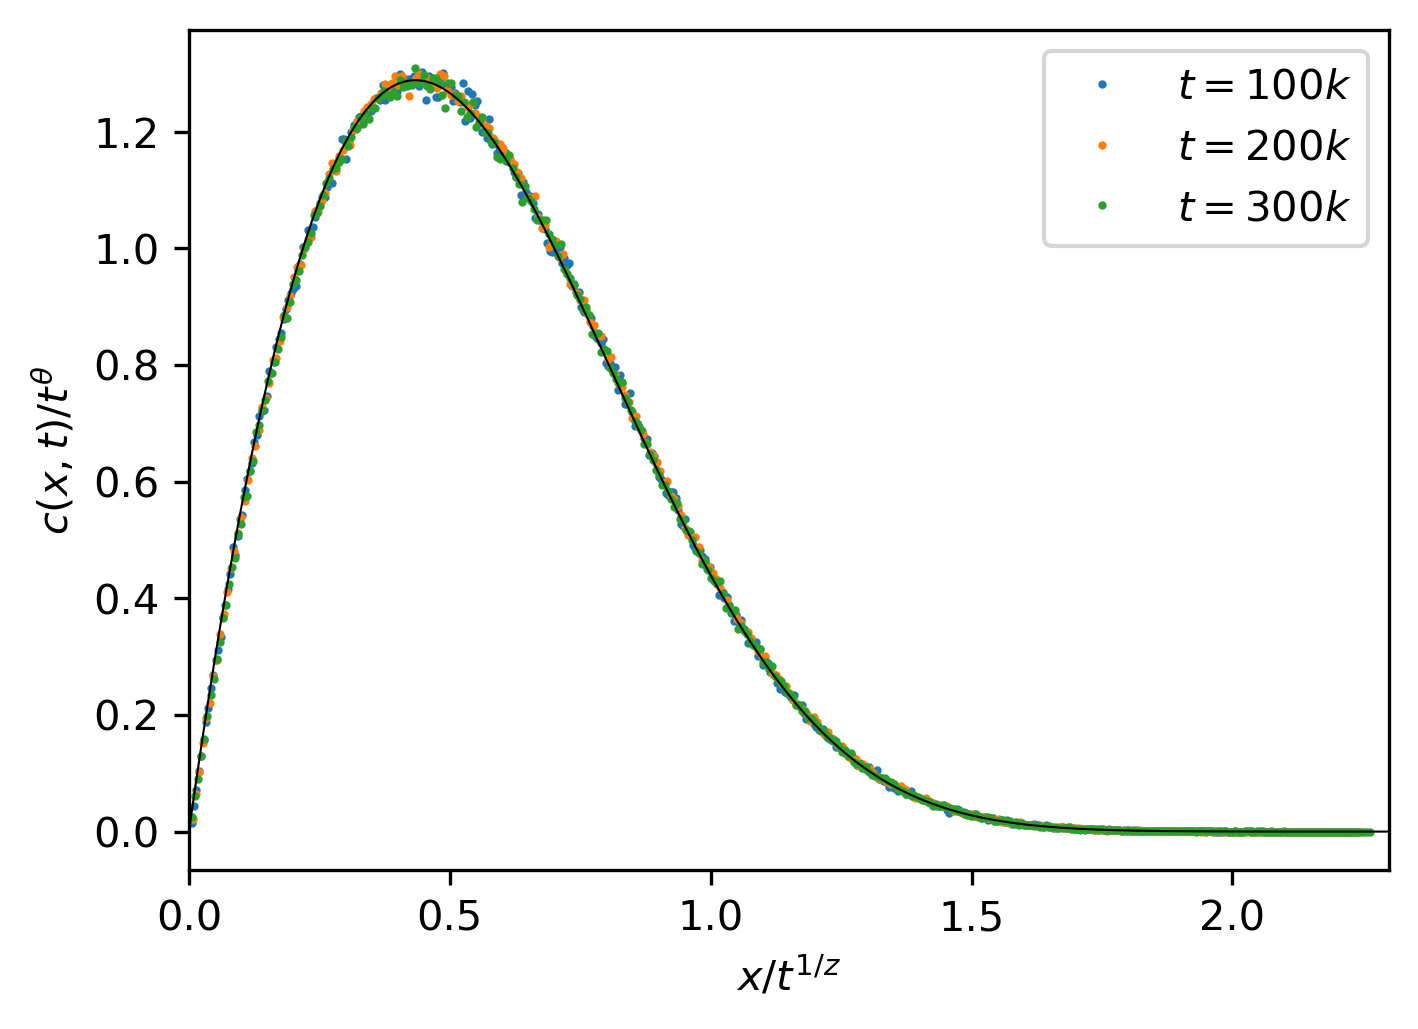

In [42]:
fig, axes = plt.subplots(1,1,figsize = (5,3.5),dpi = 300)

for i in range(3):
    time_t = min_iterationp*(i+1)
    data = np.loadtxt(files[i]).T
    x,y = data
    plt.plot(x, y,"o", markersize=1,label=r"$t={}k$".format(str(int(time_t//1000))))

xi_th = np.linspace(0,2.3,11501)
phi_th = phi_list(alphap,probp,xi_th)
plt.plot(xi_th,phi_th,color='black',linewidth=0.5)

plt.legend(loc=1)
plt.xlabel(r"$x/t^{1/z}$")
plt.ylabel(r"$c(x,t)/t^\theta$")
plt.xlim([0, 2.3])
axes.set_position([0.15, 0.15, 0.8, 0.8])

filename_fig = dir_figure + "pn_data_coll_alpha_{}.pdf".format(alphap)
print(filename_fig)
#plt.savefig(filename_fig)